In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lr.text_processing.util import pre_process_nli_df
from lr.training.util import get_ternary_label
from lr.text_processing.transformations.structural import entailment_internalization
from lr.stats.h_testing import DGP, get_matched_results, get_paired_t_statistic
from lr.stats.h_testing import get_boot_sample_under_H0,get_boot_p_value
from lr.training.language_representation import Tfidf
from lr.models.logistic_regression import LRWrapper

### Loading data

In [2]:
train_path = "data/toy/train.csv"
dev_path = "data/toy/dev.csv"
train = pd.read_csv(train_path)
dev = pd.read_csv(dev_path)
pre_process_nli_df(train)
pre_process_nli_df(dev)

### Training a model using one version of the modified data

In [3]:
max_features = 500
rho = 0.001
label_translation = get_ternary_label
transformation = entailment_internalization 

dgp = DGP(data=train, transformation=transformation, rho=rho)
train_t = dgp.get_sample()

hyperparams = {"RepresentationFunction": Tfidf,
               "max_features": max_features,
               "label_translation": label_translation,
               "penalty": "l2",
               "C": 1,
               'solver': 'lbfgs'}
lr = LRWrapper(hyperparams)
lr.fit(train_t)

### Get t statistic for the observable results and matched results

In [4]:
dev_t = transformation(dev)

results = get_matched_results(dev, dev_t, lr, lr.label_translation)
t_obs = get_paired_t_statistic(results)

print(t_obs)

-1.6783627165933783


### Get $S$ bootstrap replications under H0

In [5]:
S = 1000
t_boots = []
for _ in range(S):
    boot_sample = get_boot_sample_under_H0(results)
    t = get_paired_t_statistic(boot_sample)
    t_boots.append(t)

t_boots = pd.Series(t_boots)

### Calculating the associated p-value

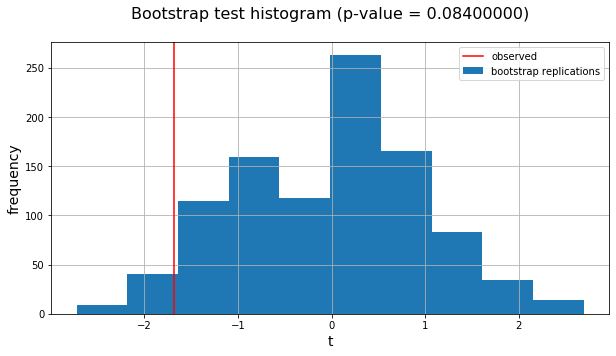

In [6]:
p_value = get_boot_p_value(t_boots, t_obs)

fig, ax = plt.subplots(figsize=(10,5))
t_boots.hist(ax=ax, label="bootstrap replications");
plt.axvline(x=t_obs, color='r', linestyle='-', label="observed");
ax.set_xlabel("t", fontsize=14);
ax.set_ylabel("frequency", fontsize=14);
ax.set_title("Bootstrap test histogram (p-value = {:.8f})".format(p_value) +"\n", fontsize=16)
plt.legend(loc="best");

In [7]:
def LIMts_test(train,dev, transformation, rho,
               Model, hyperparams, M, E, S):
    dgp = DGP(data=train, transformation=transformation, rho=rho)
    dev_t = transformation(dev)
    index_pair = []
    all_t_obs = []
    all_p_values = []
    all_t_boots = []
    t_columns = ["boot_t_{}".format(i+1) for i in range(S)]
    for m in range(M):
        train_t = dgp.get_sample()
        for e in range(E):
            index_pair.append((m+1,e+1))
            model = Model(hyperparams)
            model.fit(train_t)
            results = get_matched_results(dev, dev_t, model, model.label_translation)
            t_obs = get_paired_t_statistic(results)
            all_t_obs.append(t_obs)
            t_boots = []
            for _ in range(S):
                boot_sample = get_boot_sample_under_H0(results)
                t = get_paired_t_statistic(boot_sample)
                t_boots.append(t)
            t_boots = pd.Series(t_boots)
            p_value = get_boot_p_value(t_boots, t_obs)
            all_p_values.append(p_value)
            t_boots_t = t_boots.to_frame().transpose()
            t_boots_t.columns = t_columns
            all_t_boots.append(t_boots_t)
            
    dict_ = {"experiment_index": index_pair,
             "observable_t_stats": all_t_obs,
             "p_value":all_p_values}

    test_results = pd.DataFrame(dict_)
    t_boots_df = pd.concat(all_t_boots).reset_index(drop=True)
    combined_information = pd.merge(test_results,
                                    t_boots_df,
                                    right_index=True,
                                    left_index=True)
    return combined_information

In [8]:
tests = LIMts_test(train=train,
                   dev=dev,
                   transformation=transformation,
                   rho=0.78,
                   Model=LRWrapper,
                   hyperparams=hyperparams,
                   M=5,
                   E=1,
                   S=1000)

tests

,experiment_index,observable_t_stats,p_value,boot_t_1,boot_t_2,boot_t_3,boot_t_4,boot_t_5,boot_t_6,boot_t_7,...,boot_t_991,boot_t_992,boot_t_993,boot_t_994,boot_t_995,boot_t_996,boot_t_997,boot_t_998,boot_t_999,boot_t_1000
0,"(1, 1)",-8.382736,0.0,-0.867654,-0.833494,1.464780,-0.662994,-1.464780,0.480662,-0.308680,...,-0.833494,-0.763109,1.210455,0.132459,0.850060,-0.633089,0.397517,-0.132459,0.140035,-0.715199
1,"(2, 1)",-8.056095,0.0,-0.906390,-0.132459,-0.149079,0.000000,-0.447437,1.491465,0.850060,...,-2.162952,-0.730297,0.886388,-0.142864,-0.775761,-0.620771,-0.140035,-0.288735,1.318761,0.867654
2,"(3, 1)",-7.838234,0.0,1.070544,-0.929172,0.145873,-0.590281,-0.867654,-0.468779,-0.603572,...,0.000000,-0.288735,0.457735,1.867718,0.534905,-0.137367,0.000000,2.167888,0.833494,-0.651635
3,"(4, 1)",-8.056095,0.0,0.640841,-0.457735,-1.112830,-0.152507,-0.412257,0.674967,-0.715199,...,0.000000,-0.145873,0.603572,-1.023727,-0.145873,-0.617802,2.041676,-1.824054,-2.764980,1.775233
4,"(5, 1)",-7.838234,0.0,-0.782062,0.149079,0.000000,0.000000,-0.137367,0.000000,-1.632993,...,0.833494,0.687614,-1.135009,-0.316307,1.135009,2.002252,1.675742,-0.833494,1.135009,-1.913524


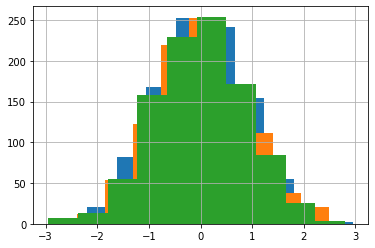

In [9]:
tests.iloc[0][["boot_t_{}".format(i+1) for i in range(1000)]].hist();
tests.iloc[2][["boot_t_{}".format(i+1) for i in range(1000)]].hist();
tests.iloc[3][["boot_t_{}".format(i+1) for i in range(1000)]].hist();